## Setup libraries

In [12]:
import pandas as pd                        # data handling
import numpy as np                         # numeric ops
import matplotlib.pyplot as plt            # plotting
import seaborn as sns                      # nicer plots (optional)
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm               # for OLS summary / p-values
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats                    # t-test

## Load Data & quick glimpse

In [22]:
df = pd.read_csv('insurance.csv')          # read CSV into pandas DataFrame

rows, columns = df.shape
print(f"Number of rows: {rows} & columns: {columns}")                            
df.head()                                  # show first 5 rows
df.info()                                  # datatypes and non-null counts
df.describe(include='all')                 # summary statistics

Number of rows: 1338 & columns: 7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


## Quick EDA

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


Text(0.5, 1.0, 'BMI vs Charges (smoker colored)')

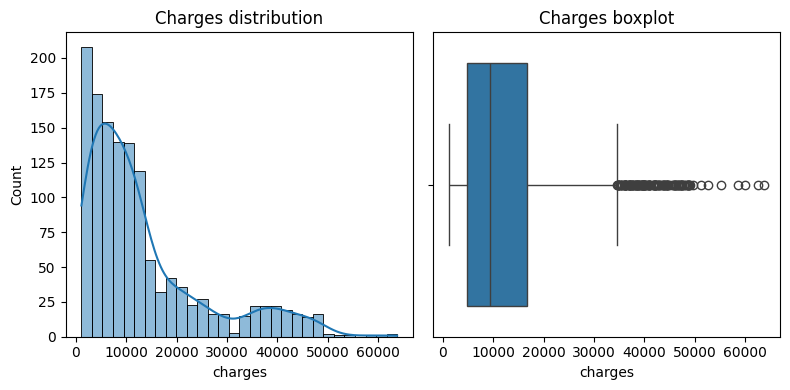

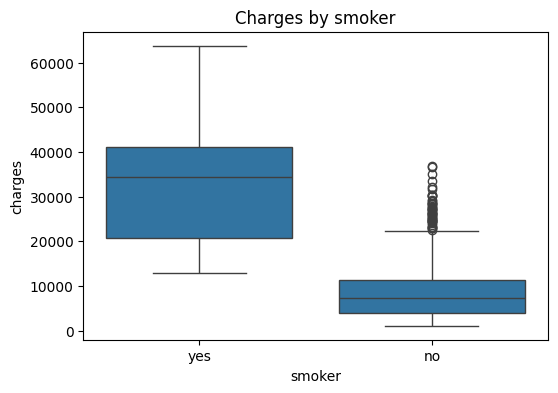

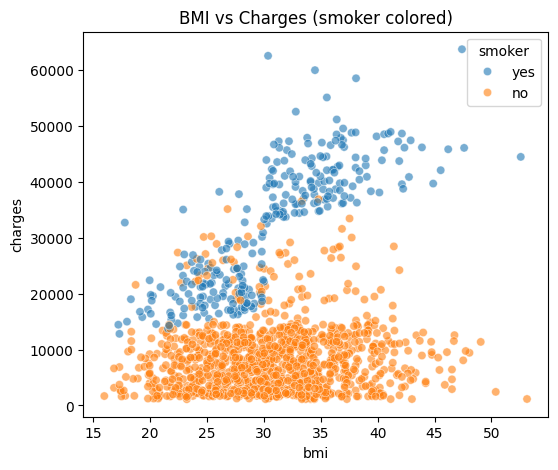

In [14]:
# Check for missing values
print(df.isnull().sum())

# Distribution of target (charges) - often skewed
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.histplot(df['charges'], kde=True)
plt.title('Charges distribution')

plt.subplot(1,2,2)
sns.boxplot(x=df['charges'])
plt.title('Charges boxplot')
plt.tight_layout()

# Compare charges by smoker status
plt.figure(figsize=(6,4))
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Charges by smoker')

# Scatter: BMI vs charges, color by smoker
plt.figure(figsize=(6,5))
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df, alpha=0.6)
plt.title('BMI vs Charges (smoker colored)')


## Preprocess

In [15]:
# ===== Preprocessing =====

# 1. Make binary dummies for 'sex' and 'smoker'
df['sex_male']   = (df['sex'] == 'male').astype(int)   # 1 if male, 0 if female
df['smoker_yes'] = (df['smoker'] == 'yes').astype(int) # 1 if smoker, 0 if non-smoker

# 2. One-hot encode 'region' (drop_first=True avoids multicollinearity)
region_dummies = pd.get_dummies(df['region'], prefix='region', drop_first=True)

# 3. Concatenate dummies back to the DataFrame
df = pd.concat([df, region_dummies], axis=1)

# 4. Optional: log-transform charges (helps with skew)
df['log_charges'] = np.log1p(df['charges'])  # log(1 + charges)

# 5. Define feature set (X) and targets (y, y_log)
feature_cols = [
    'age', 
    'bmi', 
    'children', 
    'sex_male', 
    'smoker_yes'
] + list(region_dummies.columns)

X     = df[feature_cols]       # predictors
y     = df['charges']          # original target
y_log = df['log_charges']      # log-transformed target



## Train/Test Split

In [16]:
# Split into train and test sets for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# also a split for log target if using it
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)


## Baseline OLS 
### To intrepret coefficientes & p-values

In [17]:
# One-hot encode with explicit dtype
X = pd.get_dummies(df[['age','sex','bmi','children','smoker','region']], 
                   drop_first=True, dtype=float)

# Ensure y is numeric
y = pd.to_numeric(df['charges'], errors='coerce')

# Drop any rows with NaNs
valid_idx = ~(X.isna().any(axis=1) | y.isna())
X = X[valid_idx]
y = y[valid_idx]

# Add constant and fit
X_with_const = sm.add_constant(X)
ols_model = sm.OLS(y, X_with_const).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Wed, 17 Sep 2025   Prob (F-statistic):               0.00
Time:                        14:58:03   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.194e+04    987.819  

## Regularized regression (Lasso)

In [18]:
# Use LassoCV (with scaling) to see which features survive penalization
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),                    # standardize features
    ('lasso', LassoCV(cv=5, random_state=0, n_alphas=50, max_iter=5000))
])
pipeline.fit(X_train, y_train)                       # fit on training set

# Extract coefficients (align with feature names)
coef = pipeline.named_steps['lasso'].coef_
coef_df = pd.DataFrame({'feature': X.columns, 'coef': coef})
print(coef_df.sort_values(by='coef', key=abs, ascending=False))


            feature         coef
4        smoker_yes  9415.835930
0               age  3496.091593
1               bmi  1855.660590
2          children   391.311372
7  region_southwest   -62.773075
3          sex_male     0.000000
5  region_northwest     0.000000
6  region_southeast    -0.000000


## Tree-based model + permutation importance

In [19]:
from sklearn.inspection import permutation_importance

# Fit a random forest and check feature importances and CV performance
rf = RandomForestRegressor(n_estimators=300, random_state=0)
rf.fit(X_train, y_train)

# Predict and evaluate on test
y_pred = rf.predict(X_test)
print('RF test RMSE:', mean_squared_error(y_test, y_pred, squared=False))
print('RF test MAE :', mean_absolute_error(y_test, y_pred))
print('RF R2      :', r2_score(y_test, y_pred))

# Permutation importance (more reliable than raw feature_importances_)
perm = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=42)
perm_df = pd.DataFrame({'feature': X.columns, 'importance_mean': perm.importances_mean})
print(perm_df.sort_values('importance_mean', ascending=False))


C:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RF test RMSE: 4592.505983646614
RF test MAE : 2541.9188711275374
RF R2      : 0.864146321794922
            feature  importance_mean
4        smoker_yes         1.401190
1               bmi         0.263919
0               age         0.186664
2          children         0.025892
7  region_southwest         0.004303
6  region_southeast         0.003655
5  region_northwest        -0.000686
3          sex_male        -0.002576


## Cross-validated model comparison (RMSE / R^2)

In [20]:
# Use cross-validation to compare linear vs RF
kf = KFold(n_splits=5, shuffle=True, random_state=0)
lr = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])

# negative RMSE scores via cross_val_score (sklearn expects higher=better)
cv_rmse_lr = -cross_val_score(lr, X, y, scoring='neg_root_mean_squared_error', cv=kf)
cv_rmse_rf = -cross_val_score(rf, X, y, scoring='neg_root_mean_squared_error', cv=kf)
print('Linear CV RMSE mean (5-fold):', cv_rmse_lr.mean())
print('RF CV RMSE mean (5-fold):    ', cv_rmse_rf.mean())


Linear CV RMSE mean (5-fold): 6083.284833033848
RF CV RMSE mean (5-fold):     4865.506427256672


## Statistical test
### Compare mean charges between smokers and non-smokers

In [21]:
# t-test for difference in means
smokers = df.loc[df['smoker_yes']==1, 'charges']
nonsmokers = df.loc[df['smoker_yes']==0, 'charges']
tstat, pval = stats.ttest_ind(smokers, nonsmokers, equal_var=False)  # Welch's t-test
print('t-statistic:', tstat, 'p-value:', pval)

# Cohen's d effect size (standardized mean difference)
def cohens_d(a, b):
    nx, ny = len(a), len(b)
    dof = nx + ny - 2
    pooled_sd = np.sqrt(((nx-1)*np.var(a, ddof=1) + (ny-1)*np.var(b, ddof=1)) / dof)
    return (np.mean(a) - np.mean(b)) / pooled_sd

print("Cohen's d (smokers vs non-smokers):", cohens_d(smokers, nonsmokers))


t-statistic: 32.751887766341824 p-value: 5.88946444671698e-103
Cohen's d (smokers vs non-smokers): 3.161349400737785
